In [226]:
#Posterior a la Fase 1 en donde creamos la base de datos en SQL procedemos a realizar el proceso de Transformación de la misma

import pandas as pd
from sqlalchemy import create_engine

# Configuración de la conexión con SQL Server usando SQLAlchemy
server = '127.0.0.1'
database = 'Actividad_ETL'
username = 'sa'
password = '12345678'

# Crear la URL de conexión
conn_str = f"mssql+pymssql://{username}:{password}@{server}/{database}"

# Crear el motor de conexión
engine = create_engine(conn_str)

# Ejecutar la consulta SQL y cargar los datos en un DataFrame
query = "SELECT * FROM dbo.tabla_etl_nueva1"
df = pd.read_sql(query, engine)

df.info()  # Tipos de datos, valores nulos

# Renombrar columnas: eliminar espacios y caracteres especiales
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11729 entries, 0 to 11728
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   codigo_estudiante              11729 non-null  float64
 1   Registro_SNP                   11729 non-null  object 
 2   Periodo_Presentacion1          11729 non-null  object 
 3   Periodo_Presentacion           11729 non-null  object 
 4   Puntaje_Global_ICFES           11729 non-null  float64
 5   A_Global                       11729 non-null  float64
 6   A_Lectura_Critica              11729 non-null  float64
 7   A_Matematicas                  11729 non-null  float64
 8   A_Sociales_y_Ciudadanas        11729 non-null  float64
 9   A_Ciencias_Naturales           11729 non-null  float64
 10  A_Ingles                       11729 non-null  float64
 11  A_Nivel_Ingles                 11729 non-null  object 
 12  Periodo_Academico              11727 non-null 

In [227]:
# Porcentaje de valores nulos por columna
print(df.isnull().sum().to_frame(name="Valores Nulos").assign(Porcentaje=lambda x: (x["Valores Nulos"] / len(df)) * 100))

                               Valores Nulos  Porcentaje
codigo_estudiante                          0    0.000000
registro_snp                               0    0.000000
periodo_presentacion1                      0    0.000000
periodo_presentacion                       0    0.000000
puntaje_global_icfes                       0    0.000000
a_global                                   0    0.000000
a_lectura_critica                          0    0.000000
a_matematicas                              0    0.000000
a_sociales_y_ciudadanas                    0    0.000000
a_ciencias_naturales                       0    0.000000
a_ingles                                   0    0.000000
a_nivel_ingles                             0    0.000000
periodo_academico                          2    0.017052
ano                                        2    0.017052
genero                                     2    0.017052
edad                                       2    0.017052
rango_edad                     

In [ ]:
# La única variable con una cantidad significativa de datos faltantes es "codigo_dane", con 1.085 valores nulos. 
# Sin embargo, esto representa solo el 9.25% del total de registros, por lo que no supone una gran molestia en el desarrollo del análisis. 
# Esta variable complementa la información sobre la IEM de procedencia de los estudiantes, pero la cantidad de datos faltantes es 
# lo suficientemente baja como para no justificar su eliminación.

In [228]:
# Clasificación de variables según su tipo:
# 1. Identificadores: Son variables únicas por estudiante o institución, por lo que se tratan como cadenas de texto ('object') 
#    para evitar cálculos indebidos (codigo_estudiante, registro_snp, snp,codigo_dane).
# 2. Variables categóricas que epresentan información cualitativa, por lo que se convierten en 'category' para optimizar memoria 
#    y mejorar el rendimiento en análisis estadístico y modelos.
# 3. Variables numéricas que pueden ser utilizados en cálculos estadísticos y modelado.

# Variables categóricas numéricas (se deben tratar como texto)
categorical_as_text = ["ano", "estrato_economico", "snies","codigo_dane"]

# Variables numéricas reales
numerical_columns = ["puntaje_global_icfes", "a_global", "a_lectura_critica", 
                     "a_matematicas", "a_sociales_y_ciudadanas", 
                     "a_ciencias_naturales", "a_ingles", "edad"]

# Identificadores (se mantienen como texto)
identifier_columns = ["codigo_estudiante", "registro_snp", "snp"]

# Aplicar conversiones
df[categorical_as_text] = df[categorical_as_text].astype("category")
df[numerical_columns] = df[numerical_columns].astype("float64")
df[identifier_columns] = df[identifier_columns].astype("object")
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).astype("category")

# Verificación
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11729 entries, 0 to 11728
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   codigo_estudiante              11729 non-null  category
 1   registro_snp                   11729 non-null  category
 2   periodo_presentacion1          11729 non-null  category
 3   periodo_presentacion           11729 non-null  category
 4   puntaje_global_icfes           11729 non-null  float64 
 5   a_global                       11729 non-null  float64 
 6   a_lectura_critica              11729 non-null  float64 
 7   a_matematicas                  11729 non-null  float64 
 8   a_sociales_y_ciudadanas        11729 non-null  float64 
 9   a_ciencias_naturales           11729 non-null  float64 
 10  a_ingles                       11729 non-null  float64 
 11  a_nivel_ingles                 11729 non-null  category
 12  periodo_academico              1

In [229]:
# Imputación de valores nulos en el DataFrame:
# Se reemplazan valores nulos en columnas categóricas con "No Registra" para mantener la coherencia en los datos.
# Se imputan valores nulos en columnas numéricas con 0, evitando problemas en cálculos estadísticos y modelos.

df.fillna({col: "No Registra" for col in df.select_dtypes(include=['object']).columns}, inplace=True)
df.fillna({col: 0 for col in df.select_dtypes(include=['number']).columns}, inplace=True)


In [230]:
# Reemplazar únicamente los valores 0 en 'edad' con la mediana de la población
mediana_edad = df["edad"].median()
df.loc[df["edad"] == 0, "edad"] = mediana_edad

# En muchos casos, valores de edad igual a 0 pueden representar datos faltantes o errores en la captura.
# En lugar de eliminar estos registros o usar un promedio que puede estar influenciado por valores extremos,
# reemplazamos los ceros con la mediana de la población.
# La mediana es una medida de tendencia central más robusta ante valores atípicos,
# lo que permite una mejor imputación sin sesgar la distribución original de la variable 'edad'.

In [231]:
# Verificar que ya no haya valores nulos
print(df.isnull().sum())  # Debería mostrar solo ceros

codigo_estudiante                   0
registro_snp                        0
periodo_presentacion1               0
periodo_presentacion                0
puntaje_global_icfes                0
a_global                            0
a_lectura_critica                   0
a_matematicas                       0
a_sociales_y_ciudadanas             0
a_ciencias_naturales                0
a_ingles                            0
a_nivel_ingles                      0
periodo_academico                   2
ano                                 2
genero                              2
edad                                0
rango_edad                          2
estado_civil                        2
estrato_economico                   2
municipio_nacimiento                2
pais_nacimiento                     2
ciudad_residencia                   2
snies                               2
programa1                           2
programa                            2
cod_programa                        2
plan        

In [232]:
import pandas as pd

# Listar las columnas del DataFrame
columnas_presentes = df.columns
print(columnas_presentes)

Index(['codigo_estudiante', 'registro_snp', 'periodo_presentacion1',
       'periodo_presentacion', 'puntaje_global_icfes', 'a_global',
       'a_lectura_critica', 'a_matematicas', 'a_sociales_y_ciudadanas',
       'a_ciencias_naturales', 'a_ingles', 'a_nivel_ingles',
       'periodo_academico', 'ano', 'genero', 'edad', 'rango_edad',
       'estado_civil', 'estrato_economico', 'municipio_nacimiento',
       'pais_nacimiento', 'ciudad_residencia', 'snies', 'programa1',
       'programa', 'cod_programa', 'plan', 'tipo_oferta', 'facultad',
       'nivel_de_formacion', 'modalidad_programa', 'codigo_dane', 'colegio',
       'departamento_colegio', 'ciudad_colegio', 'colegio_sector',
       'colegio_clasificacion', 'reconocimiento_del_ministerio', 'snp',
       'periodo_regular'],
      dtype='object')


In [233]:
# Filtrar solo las columnas categóricas
columnas_categoricas = df.select_dtypes(include=['category']).columns

# Mostrar las categorías únicas de cada columna categórica
for col in columnas_categoricas:
    print(f"\nCategorías en '{col}':")
    print(df[col].cat.categories)  # Muestra las categorías únicas



Categorías en 'codigo_estudiante':
Index([ 2180001.0,  2180002.0,  2180003.0,  2180004.0,  2180005.0,  2180006.0,
        2180007.0,  2180008.0,  2180009.0,  2180010.0,
       ...
       22502237.0, 22502241.0, 22502301.0, 22502302.0, 22502304.0, 22502305.0,
       22502313.0, 22502339.0, 22502340.0, 22502476.0],
      dtype='float64', length=11402)

Categorías en 'registro_snp':
Index(['AC200010508713', 'AC200010941815', 'AC200010952945', 'AC200010972638',
       'AC200011044908', 'AC200011084409', 'AC200011137454', 'AC200011152644',
       'AC200011173566', 'AC200011285584',
       ...
       'VG201810172528', 'VG201810331801', 'VG201824868840', 'VG201826425516',
       'VG201826542641', 'VG201946756332', 'VG202015643051', 'VG202210658682',
       'VG202244044152', 'VG202346237515'],
      dtype='object', length=11313)

Categorías en 'periodo_presentacion1':
Index(['2000', '20001', '20002', '2001', '20011', '20012', '2002', '20021',
       '20022', '2003', '20031', '20032', '2004', 

In [234]:
# Convertir las columnas a string para evitar problemas con categorías
coincidencias = (df["registro_snp"].astype(str) == df["snp"].astype(str)).sum()
diferencias = (df["registro_snp"].astype(str) != df["snp"].astype(str)).sum()

# Mostrar los resultados
print(f"Registros donde 'registro_snp' y 'snp' coinciden: {coincidencias}")
print(f"Registros donde 'registro_snp' y 'snp' son diferentes: {diferencias}")

Registros donde 'registro_snp' y 'snp' coinciden: 11619
Registros donde 'registro_snp' y 'snp' son diferentes: 110


In [235]:
# Tras comparar ambas columnas, observamos que tienen diferencias en algunos registros.
# Aunque en muchos casos los valores coinciden, las discrepancias indican que pueden haber sido obtenidas
# de diferentes fuentes o en distintos momentos del proceso de recolección de datos.
# Se conservan ambas columnas para evitar la pérdida de información y posibles inconsistencias en el análisis.

In [236]:
import pandas as pd

# Convertir las columnas a tipo numérico para evitar problemas de comparación
df["puntaje_global_icfes"] = pd.to_numeric(df["puntaje_global_icfes"], errors="coerce")
df["a_global"] = pd.to_numeric(df["a_global"], errors="coerce")

# Verificar si las columnas son idénticas en todos los registros
if (df["puntaje_global_icfes"] == df["a_global"]).all():
    df.drop(columns=["a_global"], inplace=True)
    print("Las columnas son idénticas. 'a_global' ha sido eliminada.")
else:
    print("Las columnas tienen diferencias, no se ha eliminado ninguna.")

Las columnas son idénticas. 'a_global' ha sido eliminada.


In [237]:
# Convertimos las columnas categóricas a string antes de reemplazar valores
df["estado_civil"] = df["estado_civil"].astype(str).replace(
    {"No registra": "No Registra", "Sin Registro": "No Registra", "Unión libre": "Unión Libre"}
).astype("category")

df["colegio_sector"] = df["colegio_sector"].astype(str).replace(
    {"NO REGISTRA": "No Registra", "SIN CLASIFICACION": "Sin Clasificación"}
).astype("category")

df["colegio_clasificacion"] = df["colegio_clasificacion"].astype(str).replace(
    {"NO REGISTRA": "No Registra", 
     "SIN CLASIFICACION": "Sin Clasificación",
     "SIN CLASIFICACIÓN": "Sin Clasificación"}  # Normaliza acentos
).astype("category")


In [238]:
df['codigo_estudiante'] = pd.to_numeric(df['codigo_estudiante'].astype(str), errors='coerce').astype('Int64')

In [239]:
print(df['codigo_estudiante'].head(10))  # Ver los primeros 10 valores print(df['codigo_estudiante'].isnull().sum())  # Contar valores nulos print(df.dtypes)  # Revisar el tipo de dato

0     2195323
1    22501672
2    22500852
3     2225642
4    22500327
5     2224980
6     2248203
7     2250908
8     2215860
9     2190665
Name: codigo_estudiante, dtype: Int64


In [240]:
# CONVERTIMOS TODAS LAS FILAS EN MAYÚSCULA PARA FACILITAR SU MANEJO

# Convertir columnas de texto (object) a mayúsculas
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.upper()

# Convertir columnas categóricas a mayúsculas evitando duplicados
columnas_categoricas = df.select_dtypes(include=['category']).columns
for col in columnas_categoricas:
    # Asegurar que todas las categorías sean strings y eliminar NaN antes de aplicar str.upper()
    categorias_limpias = df[col].cat.categories.dropna().astype(str)
    
    # Convertir a mayúsculas y eliminar duplicados
    categorias_mayusculas = list(set(categorias_limpias.str.upper()))
    
    # Asignar las nuevas categorías
    df[col] = df[col].cat.set_categories(categorias_mayusculas)




In [241]:
print(df['codigo_estudiante'].head(10))  # Ver los primeros 10 valores print(df['codigo_estudiante'].isnull().sum())  # Contar valores nulos print(df.dtypes)  # Revisar el tipo de dato

0     2195323
1    22501672
2    22500852
3     2225642
4    22500327
5     2224980
6     2248203
7     2250908
8     2215860
9     2190665
Name: codigo_estudiante, dtype: Int64


In [242]:
#Análisis exploratorio (EDA)
#para obtener estadísticas generale
df.describe() 

,codigo_estudiante,puntaje_global_icfes,a_lectura_critica,a_matematicas,a_sociales_y_ciudadanas,a_ciencias_naturales,a_ingles,edad
count,11729.0,11729.000000,11729.000000,11729.000000,11729.000000,11729.000000,11729.000000,11729.000000
mean,3405460.365845,298.303231,61.075803,60.276493,57.661467,58.819280,62.048209,19.258078
std,4763305.674324,45.821661,9.187946,10.925180,11.735442,9.694711,13.123607,4.347125
min,2180001.0,121.634619,25.000000,14.821046,12.686586,5.000000,0.000000,14.000000
25%,2200027.0,267.000000,55.000000,53.000000,51.000000,52.000000,53.000000,17.000000
50%,2221664.0,300.384615,62.000000,61.000000,59.000000,59.000000,62.000000,18.000000
75%,2240693.0,332.307692,68.000000,68.000000,66.000000,66.000000,72.000000,19.000000
max,22502476.0,471.153846,100.000000,100.000000,100.000000,100.000000,100.000000,55.000000


In [243]:
# Estadísticas descriptivas de variables numéricas en el DataFrame

# 'puntaje_global_icfes' y sus componentes tienen un rango entre ~121 y 471, con una media de ~298.
# 'a_lectura_critica', 'a_matematicas', 'a_sociales_y_ciudadanas', 'a_ciencias_naturales' y 'a_ingles' 
#  presentan valores entre 0 y 100, con promedios alrededor de 60.
# 'edad' tiene un promedio de 19.2 años.


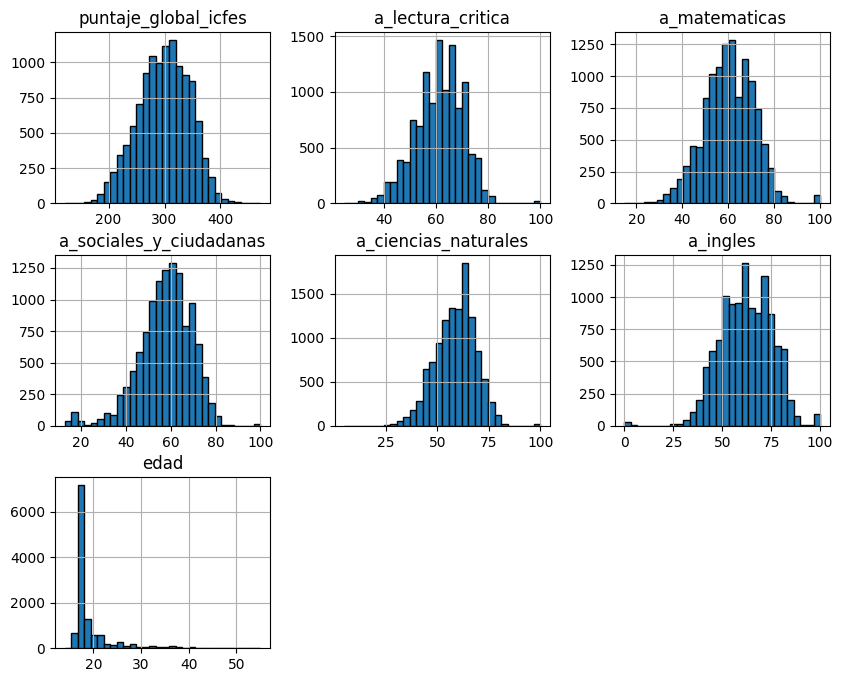

In [244]:
import matplotlib.pyplot as plt

# Seleccionar solo las variables específicas
vars_hist = [
    'puntaje_global_icfes', 'a_lectura_critica', 'a_matematicas',
    'a_sociales_y_ciudadanas', 'a_ciencias_naturales', 'a_ingles',
    'edad'
]

# Generar histogramas solo para las variables seleccionadas
df[vars_hist].hist(figsize=(10, 8), bins=30, edgecolor='black')

# Mostrar los gráficos
plt.show()


In [245]:
# Análisis de histogramas de variables cuantitativas:
# 
# 1. Las distribuciones de los puntajes de las áreas evaluadas en el ICFES (puntaje_global_icfes, 
#    a_lectura_critica, a_matematicas, a_sociales_y_ciudadanas, a_ciencias_naturales, a_ingles) 
#    muestran una forma aproximadamente normal, con una leve asimetría a la izquierda en algunos casos.
#
# 2. El puntaje global del ICFES y las pruebas específicas tienden a concentrarse en valores intermedios, 
#    con pocas observaciones en los extremos, lo que sugiere que la mayoría de los estudiantes 
#    tienen desempeños cercanos a la media.
#
# 3. La distribución de la variable 'edad' presenta una fuerte asimetría a la derecha, 
#    con una alta concentración de valores en torno a los 17-18 años, lo cual es esperable en 
#    estudiantes que presentan pruebas de ingreso a la educación superior.

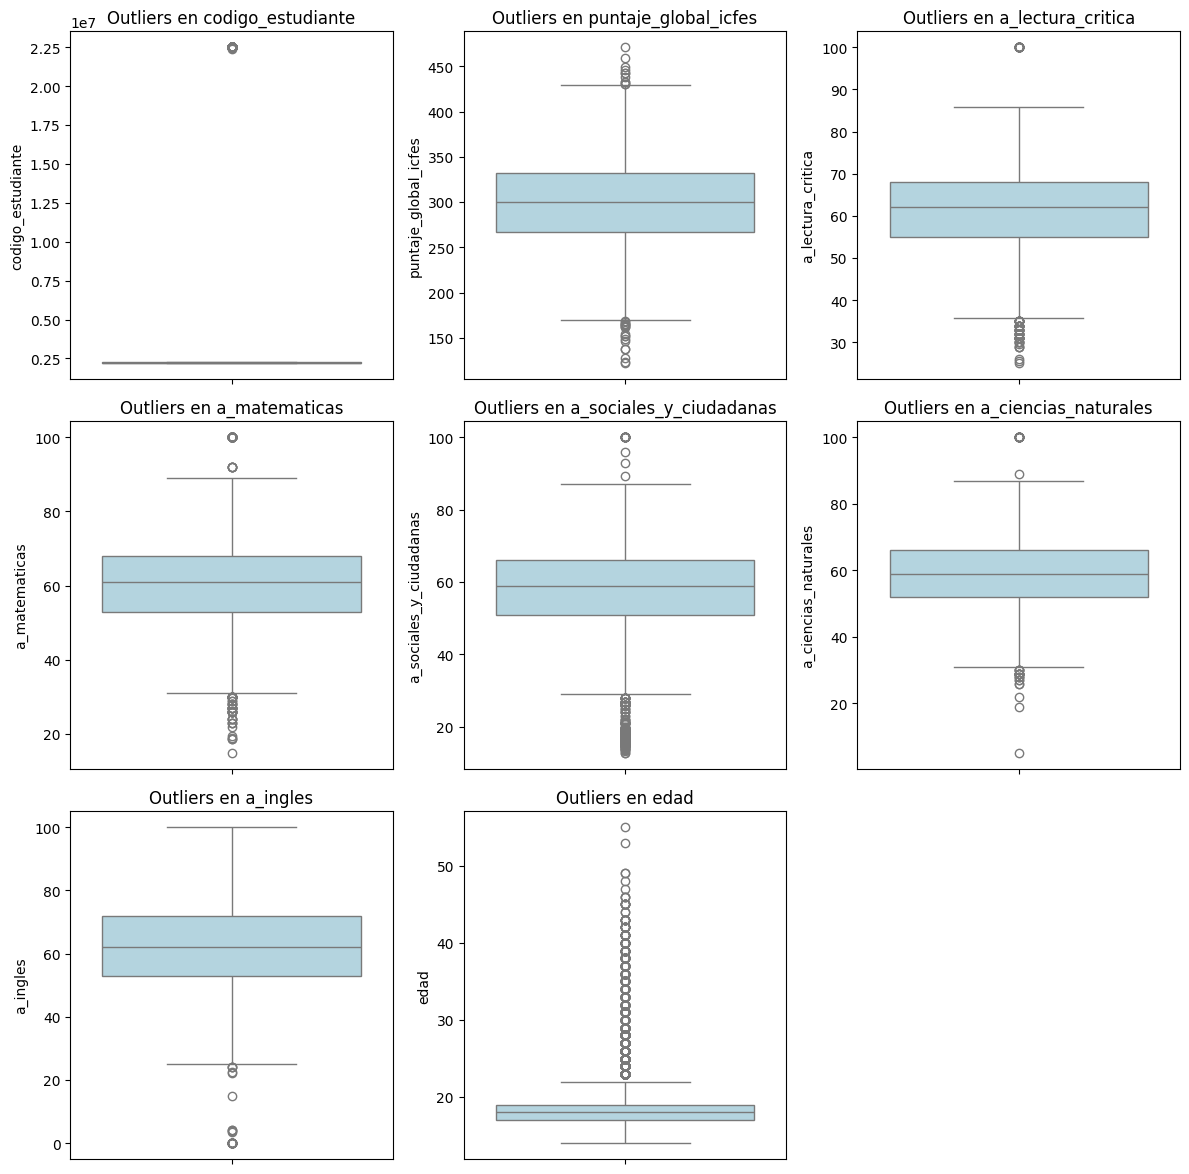

In [246]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir variables numéricas automáticamente
vars_numericas = df.select_dtypes(include=['number']).columns.tolist()

# Verificar que haya variables numéricas antes de graficar
if not vars_numericas:
    print("No hay variables numéricas en el DataFrame.")
else:
    # Configurar el tamaño de la figura dinámicamente
    num_vars = len(vars_numericas)
    filas = (num_vars // 3) + (num_vars % 3 > 0)  # Calcula el número de filas dinámicamente

    plt.figure(figsize=(12, 4 * filas))  # Ajusta el tamaño según la cantidad de variables

    # Graficar boxplots para cada variable numérica
    for i, col in enumerate(vars_numericas, 1):
        plt.subplot(filas, 3, i)  # Ajustar dinámicamente filas y columnas
        sns.boxplot(y=df[col], color="lightblue")
        plt.title(f"Outliers en {col}")

    plt.tight_layout()
    plt.show()


In [ ]:
# Gráficos de Boxplot para la detección de valores atípicos en las variables numéricas.

# Observaciones:
# Se han identificado valores atípicos en todas las variables evaluadas utilizando el método del rango intercuartílico (IQR).
# Estos valores atípicos pueden corresponder a variabilidad natural en la población o a posibles registros con características particulares.
# En "puntaje_global_icfes", se observan valores atípicos tanto en la parte inferior como en la superior, lo que indica que hay estudiantes con rendimientos excepcionalmente altos y bajos.
# En las áreas específicas ("a_lectura_critica", "a_matematicas", "a_sociales_y_ciudadanas", "a_ciencias_naturales", "a_ingles"), los valores extremos en la parte baja pueden deberse a condiciones particulares en la formación previa de los estudiantes.
# El Análisis del boxplot de "edad":
# La mayoría de los datos están entre 17 y 22 años, con una mediana central en este rango.
# Se observan múltiples outliers, especialmente por encima de 50 años, lo que indica una distribución sesgada a la derecha.


In [247]:
#Carga de datos transformados a SQL
df.to_sql("TRANSFORMACION", engine, if_exists="replace", index=False)


16